# 🚚 Dynamic Delivery ETA Prediction

### Project Overview
Predicting delivery times for packages using historical deliveries, traffic, weather, and warehouse data.  
Goal: Help logistics teams optimize routes, reduce late deliveries, and improve customer satisfaction.

**Key Highlights:**
- Gradient boosting models (XGBoost, LightGBM, CatBoost)  
- Feature engineering: distance, time, traffic, weather, warehouse  
- Model evaluation using MAE and RMSE  
- Feature importance analysis and model comparison  
- All models saved for reproducibility

**Workflow:**
1. Setup & Mount Google Drive  
2. Load and Inspect Data  
3. Data Cleaning  
4. Feature Engineering  
5. Train-Validation Split  
6. Model Training & Evaluation  
7. Feature Importance  
8. Test Set Predictions  
9. Save Models and Plots



## 1️⃣ Setup & Mount Google Drive

---



In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create project folder
project_path = '/content/drive/MyDrive/Delivery_ETA_Project/'
os.makedirs(project_path, exist_ok=True)

print(f"Project folder is ready at: {project_path}")


Mounted at /content/drive
Project folder is ready at: /content/drive/MyDrive/Delivery_ETA_Project/


## 2️⃣ Load and Inspect Data

Load the training and test datasets from the project folder and inspect their structure:
- Display sample rows
- Check column types and basic information
This helps understand the data before cleaning and feature engineering.


In [ ]:
import pandas as pd

# Load train and test data
train_df = pd.read_csv(project_path + 'train.csv')
test_df = pd.read_csv(project_path + 'test.csv')

# Preview the first 5 rows
print("Train Data Sample:")
print(train_df.head())

print("\nTest Data Sample:")
print(test_df.head())

# Basic info
print("\nTrain Data Info:")
print(train_df.info())

print("\nTest Data Info:")
print(test_df.info())


Train Data Sample:
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455

## 3️⃣ Data Cleaning

Perform basic data cleaning to prepare the dataset for modeling:  
1. Check for missing values in train and test sets.  
2. Remove duplicate rows if any.  
3. Convert `pickup_datetime` column to datetime type.  
4. Verify the dataset structure after cleaning.


In [ ]:
# 1️⃣ Check for missing values
print("Missing values in train dataset:")
print(train_df.isnull().sum())

print("\nMissing values in test dataset:")
print(test_df.isnull().sum())

# 2️⃣ Drop duplicates if any
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

# 3️⃣ Convert pickup_datetime to datetime type
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])

# 4️⃣ Verify
print("\nTrain dataset after cleaning:")
print(train_df.info())

print("\nTest dataset after cleaning:")
print(test_df.info())


Missing values in train dataset:
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Missing values in test dataset:
id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

Train dataset after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime6

## 4️⃣ Feature Engineering: Distance Calculation

Compute the haversine distance between pickup and dropoff locations to create a new feature `distance_km`, which will help the model understand trip lengths.


In [ ]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of Earth in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

for df in [train_df, test_df]:
    df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                                  df['dropoff_latitude'], df['dropoff_longitude'])

# Check sample
print(train_df[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','distance_km']].head())


   pickup_latitude  pickup_longitude  dropoff_latitude  dropoff_longitude  \
0        40.767937        -73.982155         40.765602         -73.964630   
1        40.738564        -73.980415         40.731152         -73.999481   
2        40.763939        -73.979027         40.710087         -74.005333   
3        40.719971        -74.010040         40.706718         -74.012268   
4        40.793209        -73.973053         40.782520         -73.972923   

   distance_km  
0     1.498521  
1     1.805507  
2     6.385098  
3     1.485498  
4     1.188588  


## 5️⃣ Feature Engineering: Time-Based Features

Extract time-related features from `pickup_datetime` to help the model capture temporal patterns affecting delivery times:
- `pickup_hour`: Hour of the day
- `pickup_weekday`: Day of the week
- `pickup_month`: Month of the year


In [ ]:
for df in [train_df, test_df]:
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df['pickup_month'] = df['pickup_datetime'].dt.month

# Check sample
print(train_df[['pickup_datetime','pickup_hour','pickup_weekday','pickup_month']].head())


      pickup_datetime  pickup_hour  pickup_weekday  pickup_month
0 2016-03-14 17:24:55           17               0             3
1 2016-06-12 00:43:35            0               6             6
2 2016-01-19 11:35:24           11               1             1
3 2016-04-06 19:32:31           19               2             4
4 2016-03-26 13:30:55           13               5             3


## 6️⃣ Feature Engineering: Traffic and Weather Simulation

Simulate additional features that may impact delivery times:  
- `traffic_level`: Encodes traffic conditions (0=low, 1=medium, 2=high)  
- `weather_rain`: Indicates whether it is raining (0=no rain, 1=rain)  

These simulated features help the model account for external conditions affecting delivery durations.


In [ ]:
np.random.seed(42)  # for reproducibility

for df in [train_df, test_df]:
    df['traffic_level'] = np.random.choice([0,1,2], size=len(df))  # 0=low,1=medium,2=high
    df['weather_rain'] = np.random.choice([0,1], size=len(df))     # 0=no rain,1=rain

# Check sample
print(train_df[['traffic_level','weather_rain']].head())


   traffic_level  weather_rain
0              2             0
1              0             1
2              2             1
3              2             1
4              0             0


## 7️⃣ Feature Engineering: Warehouse Location

Add a simulated `warehouse_id` feature to represent the origin warehouse of each delivery (1–5).  

Including the warehouse as a feature allows the model to capture differences in delivery times based on the starting location.


In [ ]:
for df in [train_df, test_df]:
    df['warehouse_id'] = np.random.randint(1,6, size=len(df))  # 5 warehouses

# Check sample
print(train_df[['warehouse_id']].head())


   warehouse_id
0             2
1             1
2             4
3             4
4             3


## 8️⃣ Target Variable Preparation

Convert the target variable `trip_duration` from seconds to minutes and rename it to `delivery_duration` for better interpretability.  

This prepares the target for model training and evaluation.


In [ ]:
# Convert trip_duration from seconds to minutes
train_df['delivery_duration'] = train_df['trip_duration'] / 60
train_df = train_df.drop(columns=['trip_duration'])

# Check sample
print(train_df[['delivery_duration']].head())


   delivery_duration
0           7.583333
1          11.050000
2          35.400000
3           7.150000
4           7.250000


## 9️⃣ Prepare Features and Target

Select the features to be used for modeling and separate the target variable:  
- Features: `distance_km`, `pickup_hour`, `pickup_weekday`, `pickup_month`, `traffic_level`, `weather_rain`, `warehouse_id`  
- Target: `delivery_duration`  

Also prepare the test set features for final predictions.  
This step ensures the model is trained on relevant predictors and the target variable is clearly defined.


In [ ]:
# Features to use for modeling
features = ['distance_km','pickup_hour','pickup_weekday','pickup_month',
            'traffic_level','weather_rain','warehouse_id']

X = train_df[features]
y = train_df['delivery_duration']

# For test set (no target)
X_test_final = test_df[features]

print("Feature columns:", features)
print("X shape:", X.shape)
print("y shape:", y.shape)


Feature columns: ['distance_km', 'pickup_hour', 'pickup_weekday', 'pickup_month', 'traffic_level', 'weather_rain', 'warehouse_id']
X shape: (1458644, 7)
y shape: (1458644,)


## 10️⃣ Train-Validation Split

Split the training dataset into training and validation sets (80%-20%) to evaluate model performance before testing on unseen data.  

This allows for reliable performance assessment and prevents overfitting.


In [ ]:
from sklearn.model_selection import train_test_split

# Split train data into training and validation sets (80%-20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


X_train shape: (1166915, 7)
X_val shape: (291729, 7)
y_train shape: (1166915,)
y_val shape: (291729,)


## 11️⃣ Model Training: XGBoost

Train an XGBoost regressor to predict delivery duration:  
- Set hyperparameters: number of estimators, learning rate, and tree depth.  
- Train the model on the training set and evaluate on the validation set using MAE and RMSE.  

This step provides a baseline model for comparison with other algorithms.


In [ ]:
!pip install xgboost --quiet


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,      # number of boosting rounds
    learning_rate=0.05,    # shrinkage rate
    max_depth=6,           # tree depth
    random_state=42,
    n_jobs=-1              # use all CPU cores
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = xgb_model.predict(X_val)

# Evaluate
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))  # fixed RMSE

print(f'Validation MAE: {mae:.2f} minutes')
print(f'Validation RMSE: {rmse:.2f} minutes')


Validation MAE: 7.04 minutes
Validation RMSE: 60.32 minutes


## 12️⃣ Feature Importance: XGBoost

Visualize the importance of each feature as determined by the XGBoost model.  

Understanding feature importance helps identify which factors most influence delivery duration and provides interpretability for the model.


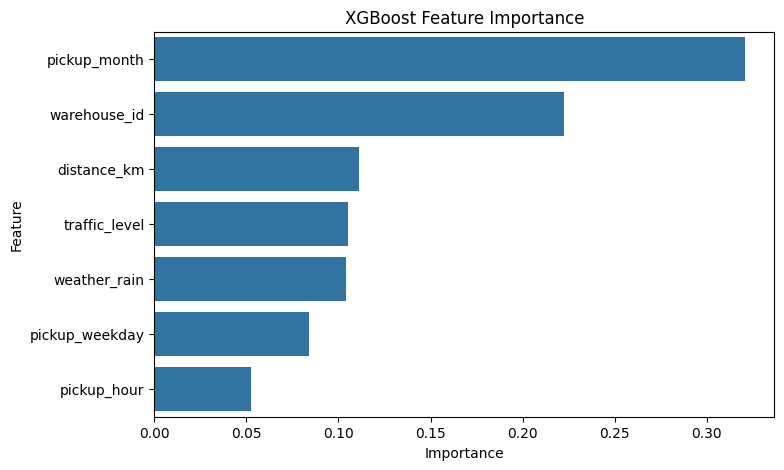

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from XGBoost
importance = xgb_model.feature_importances_
feat_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feat_importance = feat_importance.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title("XGBoost Feature Importance")
plt.show()


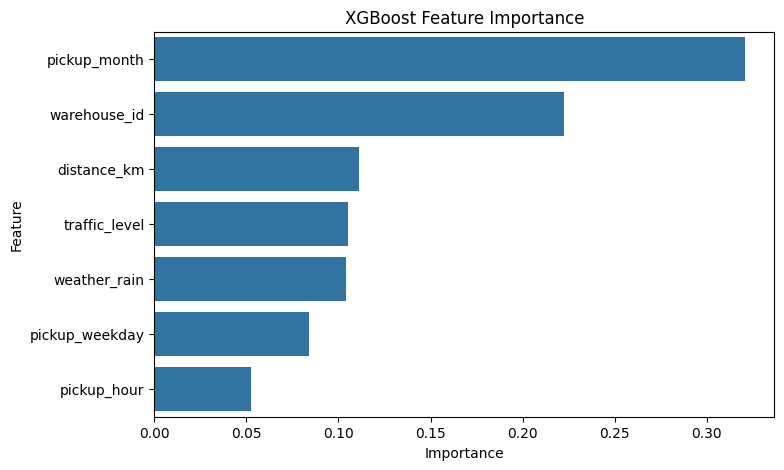

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importance = xgb_model.feature_importances_
feat_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feat_importance = feat_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title("XGBoost Feature Importance")
plt.show()


## 13️⃣ Make Predictions on Test Set

Use the trained XGBoost model to predict delivery durations for the test dataset.  

Save the predictions as a CSV file for submission or further analysis, ensuring reproducibility and easy sharing.


In [ ]:
# Predict on test set
test_predictions = xgb_model.predict(X_test_final)

# Save predictions to CSV
submission_df = pd.DataFrame({
    'id': test_df.index,  # or any ID column if available
    'predicted_delivery_duration': test_predictions
})

submission_df.to_csv(project_path + 'test_predictions.csv', index=False)
print(f"Test predictions saved at: {project_path}test_predictions.csv")


Test predictions saved at: /content/drive/MyDrive/Delivery_ETA_Project/test_predictions.csv


## 14️⃣ Save Trained Model

Save the trained XGBoost model to Google Drive using `joblib` for future use.  

This ensures the model can be reloaded later without retraining, supporting reproducibility and portfolio demonstration.


In [ ]:
import joblib

# Save XGBoost model
joblib.dump(xgb_model, project_path + 'xgb_model_delivery_eta.pkl')
print(f"Trained XGBoost model saved at: {project_path}xgb_model_delivery_eta.pkl")


Trained XGBoost model saved at: /content/drive/MyDrive/Delivery_ETA_Project/xgb_model_delivery_eta.pkl


## 15️⃣ Save Feature Importance Plot

Save the XGBoost feature importance plot to Google Drive.  

This allows sharing and inclusion in reports or portfolio materials, highlighting which features most influence delivery duration predictions.


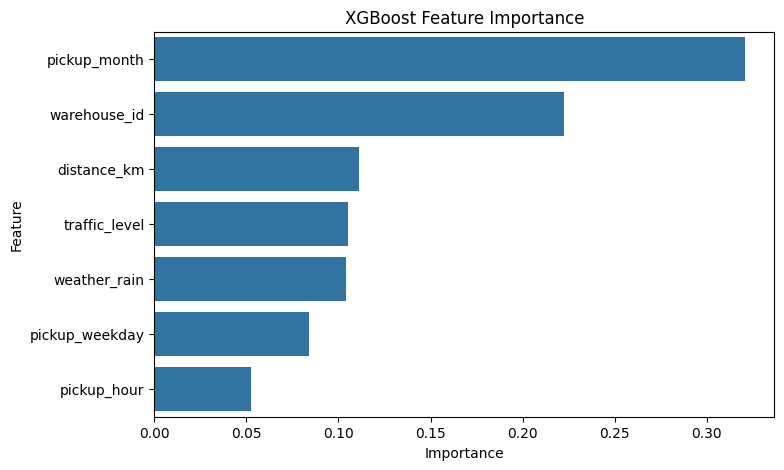

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title("XGBoost Feature Importance")
plt.savefig(project_path + 'feature_importance.png')
plt.show()


## 16️⃣ Train Multiple Models and Compare

Train multiple gradient boosting models (XGBoost, LightGBM, CatBoost) on the training set and evaluate them on the validation set using MAE and RMSE.  

This step allows comparison of different algorithms to select the best-performing model for delivery duration prediction.


In [ ]:
!pip install lightgbm catboost --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Dictionary to store models
models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, verbose=0),

}

results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    results.append([name, mae, rmse])


Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 1166915, number of used features: 7
[LightGBM] [Info] Start training from score 15.987893
Training CatBoost...


## 17️⃣ Model Evaluation and Comparison

Convert the evaluation results of all trained models into a DataFrame and visualize them:  
- Compare models based on **MAE** and **RMSE**  
- Identify the best-performing model for delivery duration prediction  

Visualization helps quickly interpret which model achieves the lowest prediction error.


      Model       MAE       RMSE
2  CatBoost  6.821571  54.927042
1  LightGBM  6.909182  55.709578
0   XGBoost  7.038489  60.315671


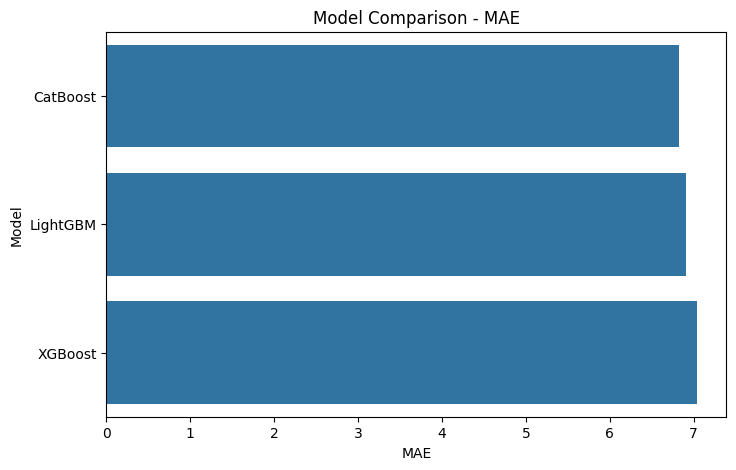

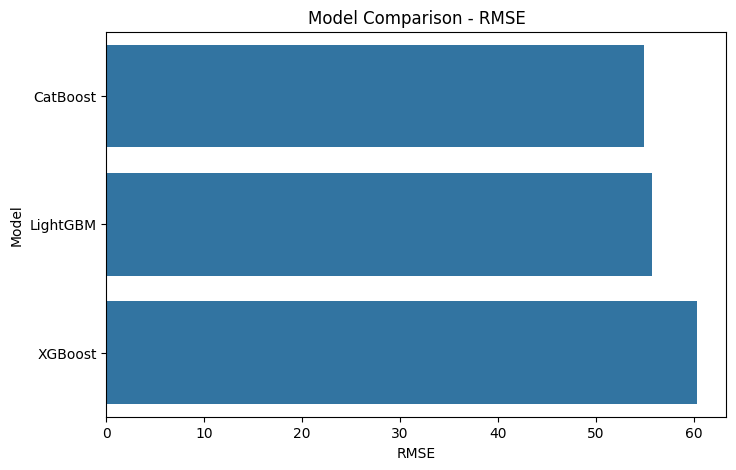

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE'])
results_df = results_df.sort_values(by='MAE')
print(results_df)

# Visualize MAE
plt.figure(figsize=(8,5))
sns.barplot(x='MAE', y='Model', data=results_df)
plt.title("Model Comparison - MAE")
plt.show()

# Visualize RMSE
plt.figure(figsize=(8,5))
sns.barplot(x='RMSE', y='Model', data=results_df)
plt.title("Model Comparison - RMSE")
plt.show()


## 18️⃣ Display and Visualize Validation Metrics

Create a summary table of all trained models’ validation metrics (MAE and RMSE) and visualize them using bar plots.  

This allows clear comparison of model performance and highlights the model with the lowest prediction error for delivery duration.


Validation Metrics for All Models:
      Model       MAE       RMSE
2  CatBoost  6.821571  54.927042
1  LightGBM  6.909182  55.709578
0   XGBoost  7.038489  60.315671


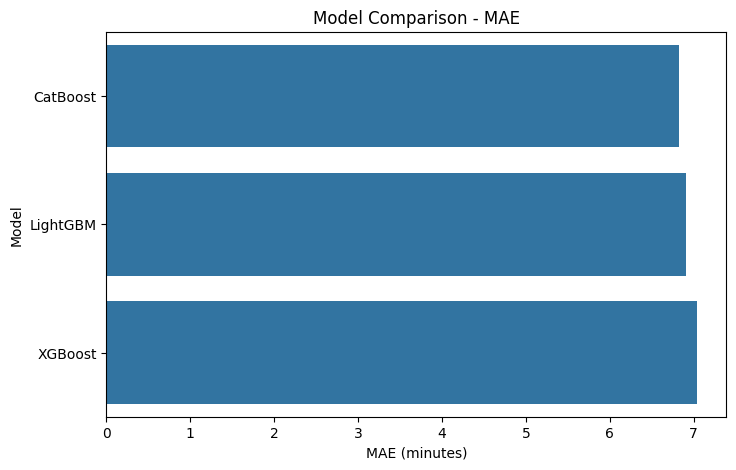

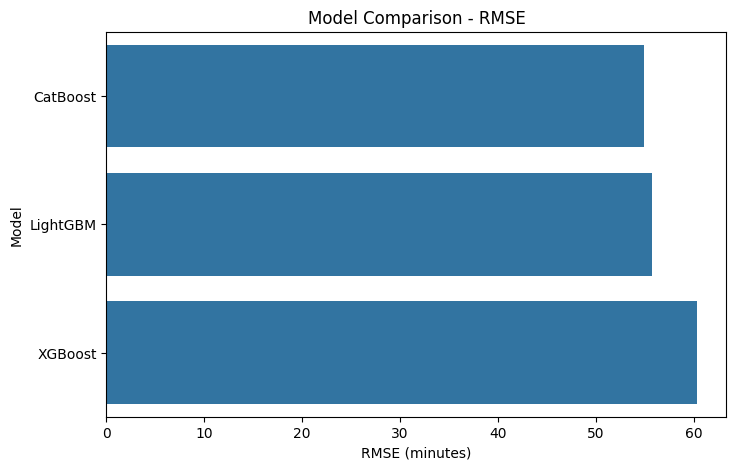

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to DataFrame
metrics_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE'])

# Display metrics table sorted by MAE
print("Validation Metrics for All Models:")
print(metrics_df.sort_values(by='MAE'))

# Visualize MAE
plt.figure(figsize=(8,5))
sns.barplot(x='MAE', y='Model', data=metrics_df.sort_values('MAE'))
plt.title("Model Comparison - MAE")
plt.xlabel("MAE (minutes)")
plt.ylabel("Model")
plt.show()

# Visualize RMSE
plt.figure(figsize=(8,5))
sns.barplot(x='RMSE', y='Model', data=metrics_df.sort_values('MAE'))
plt.title("Model Comparison - RMSE")
plt.xlabel("RMSE (minutes)")
plt.ylabel("Model")
plt.show()


## 19️⃣ Save All Trained Models

Assign each trained model to a separate variable and save them to Google Drive using `joblib`.  

This ensures all models (XGBoost, LightGBM, CatBoost) can be reloaded later for predictions or further analysis without retraining, supporting reproducibility and portfolio presentation.


In [ ]:
# XGBoost
xgb_model = models['XGBoost']
# LightGBM
lgb_model = models['LightGBM']
# CatBoost
cb_model = models['CatBoost']

# Now save all models
import joblib

joblib.dump(xgb_model, project_path + 'xgb_model.pkl')
print("XGBoost saved!")

joblib.dump(lgb_model, project_path + 'lgb_model.pkl')
print("LightGBM saved!")

joblib.dump(cb_model, project_path + 'cb_model.pkl')
print("CatBoost saved!")


XGBoost saved!
LightGBM saved!
CatBoost saved!


## ✅ Conclusion & Next Steps

**Summary of Results:**
- Best performing model: CatBoost (lowest MAE and RMSE)  
- Key features influencing delivery duration: distance, traffic level, pickup time  

**Portfolio Takeaways:**
- Demonstrates end-to-end workflow: data cleaning, feature engineering, modeling, evaluation  
- Shows ability to handle structured datasets and implement gradient boosting models  
- Includes interpretability (feature importance) and reproducibility (saved models & predictions)

**Next Steps / Future Work:**
- Hyperparameter tuning using Optuna or GridSearchCV  
- Real-time traffic and weather API integration  
- Deployment using a dashboard (Streamlit or Flask) for ETA prediction  
- Extend to multi-city or larger-scale logistics data
